# Building Blocks of the Deep Learning Model

# The Perceptrons, Layers, and Networks

-   Perceptron \< Layer \< Network
-   Need non-linear activation functions to model complex functions
-   Stacking multiple of them leads to obviously interesting complex functions.
-   We do not know the parameters of this large function that the entire network represents. We need to learn them.
-   Learning is done by adjusting the parameters of the network to minimize the error between the predicted value and the actual value.
    -   Using calculus to extremize the error function with respect to the parameters of the network.

# Classification with a Multi-Layer Perceptron

We’ll use synthetic data to create two classes of points that are not linearly separable. We’ll then use a multi-layer perceptron to classify these points. This note is nothing but some commentary added on Karpathy’s [micrograd](https://github.com/karpathy/micrograd) example.

We’ll solve a classification problem with a multi-layer perceptron. The problem is simple - given a point in a 2D space, we want to predict which class it belongs to. The two classes and their members are synthetically generated.

## The setup

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from sklearn.datasets import make_moons

np.random.seed(1337)
random.seed(1337)

## The dataset

`make_moons` from `sklearn.datasets` creates two interleaving half circles. We’ll use this to create a simple 2D dataset with two classes. Moon - because you can see the (non-linear) crescent shape of the two classes, and the points are not linearly separable.

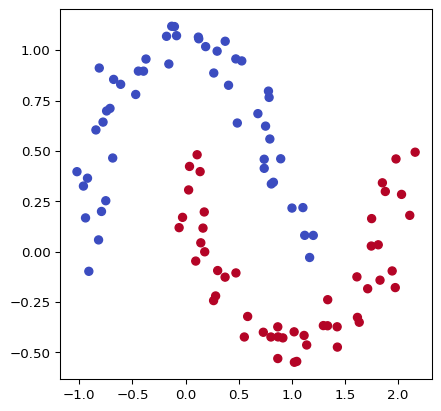

In [2]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')

## The task

What we want is a function that, given any of those points, can tell us which class it belongs to. The simplest way to do it is to define a dictionary that maps each point to a class. But that’s not what we want, because that’s not a realistic problem to solve.

## Generalization

The promise of the neural network is, like the brain, to generalize. That is, to be able to predict the class of a point that it has never seen before. This is the key to the success of neural networks.

So, we imagine that the solution is a function that can, given any point in this 2D space, choose a “side.” This side is the class that the point belongs to. So, a curve that can somehow separate the two classes is what we are looking for.

As we have stated before (without any formal proof), a network of stacked perceptrons can model any function. So, let’s model this conjectured function with a network of perceptrons.

# The Multi-Layer Perceptron

Let’s visualize the network we are going to build. It has 2 input neurons, 3 neurons in the first hidden layer, and 2 output neuron. The input neurons represent the x and y coordinates of the point, and the output neurons represent the class of the point - one for each class. Naive, but simple to understand.

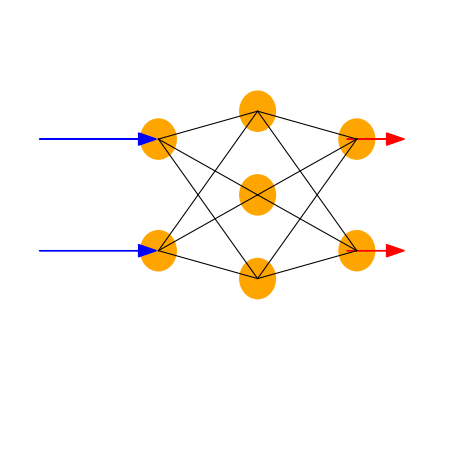

In [3]:
def draw_mlp(layers):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1.5, len(layers))
    ax.set_ylim(-max(layers) / 1.3, max(layers) / 1.8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    positions = {}

    # Draw neurons
    for i, layer_size in enumerate(layers):
        y_positions = np.linspace(-layer_size / 4, layer_size / 4, layer_size)
        for j, y in enumerate(y_positions):
            positions[(i, j)] = (i, y)
            circle = plt.Circle((i, y), 0.18, fill=True, color="orange")
            ax.add_patch(circle)

    # Draw connections
    for i in range(len(layers) - 1):
        for j in range(layers[i]):
            for k in range(layers[i + 1]):
                start = positions[(i, j)]
                end = positions[(i + 1, k)]
                ax.plot([start[0], end[0]], [start[1], end[1]], "k-", lw=0.8)

    # Draw input arrows
    for j in range(layers[0]):
        start = (-1.2, positions[(0, j)][1])
        end = positions[(0, j)]
        ax.arrow(start[0], start[1], end[0] - start[0] - 0.2, end[1] - start[1], 
                 head_width=0.11, head_length=0.18, fc="blue", ec="blue")
    
    # Draw output arrows
    for j in range(layers[-1]):
        start = positions[(len(layers) - 3, j)]
        end = (len(layers) - 0.8, start[1])
        ax.arrow(start[0] + 1.9, start[1], end[0] - start[0] - 1.8, end[1] - start[1], 
                 head_width=0.11, head_length=0.18, fc="red", ec="red")

    plt.show()

draw_mlp([2, 3, 2])

Let’s attempt to solve this classification problem with a model that takes two inputs (the x and y coordinates of the point) and outputs a single value. This value will be the class of the point. We will use a multi-layer perceptron with 2 hidden layers, each with 16 neurons.

In [4]:
model = MLP(2, [16, 16, 1])
print("Number of parameters in the model is", len(model.parameters()))

Number of parameters in the model is 337

To train this network, we use our trusty friend - calculus, trying to minimize the error between the predicted class and the actual class. Because reducing the error means the network does what we want it to do, and calculus is great at helping us find minima or maxima by way of slopes.

Intuitively, the slope gives us an indication of the amount and direction of the adjustments. Larger slopes mean larger adjustments. This is adjusted by a learning rate, which is a hyperparameter that we need to tune.

In [5]:
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    scores = list(map(model, inputs))

    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5

Now, let’s let loose our optimization algorithm. Run the network through the input a 100 times, and adjust the parameters each time to reduce the error. And see where we land.

In [6]:
for k in range(100):
    total_loss, acc = loss()

    model.zero_grad()
    total_loss.backward()

    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.8958441028683222, accuracy 50.0%
step 10 loss 0.24507023853658055, accuracy 91.0%
step 20 loss 0.1897752285608764, accuracy 91.0%
step 30 loss 0.11731297569011848, accuracy 95.0%
step 40 loss 0.06016009895234466, accuracy 100.0%
step 50 loss 0.09875114765619628, accuracy 96.0%
step 60 loss 0.03259711157810232, accuracy 99.0%
step 70 loss 0.01422987006592693, accuracy 100.0%
step 80 loss 0.01231850080051585, accuracy 100.0%
step 90 loss 0.010984458327280174, accuracy 100.0%

Wow, looks like it wasn’t hard at all! The network learnt pretty quickly and the accuracy improved pretty quickly. But note that it still oscillates a bit. Because the setup is simple, the network learns quickly. But in real-world problems, it might take a lot more time and effort to train a network.

Let’s visualize the decision boundary of the network.

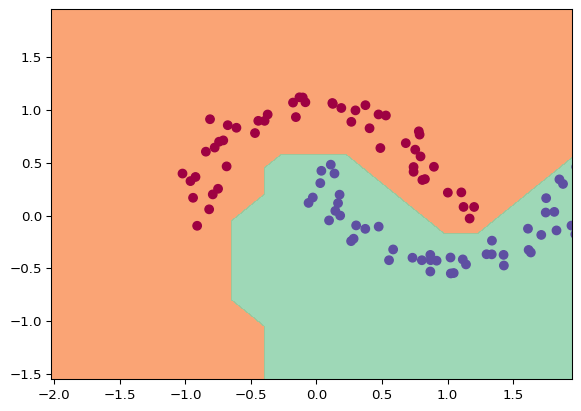

In [7]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), yy.max())
plt.ylim(yy.min(), yy.max())

So, there’s that for a simple, 2-class setup.

There are more. Let’s look at some generative models next.

# Generation

We will explore another model, but this time, we will not be building it from scratch. We will use a pre-built model from the `torch` library. We will use a Generative Adversarial Network (GAN) to generate new samples from the same distribution as the training data.